### Importing Libaries

In [16]:
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
import optuna
from skopt import BayesSearchCV
pd.set_option('display.max_columns', None)

- Reading training data
- Snow_depth column has most values as 0, so filling it with mode = 0
- Dropping date and time because they do not have an impact on wildfire. Seasonality is taken care of by weather variables

In [5]:
training_df=pd.read_csv("../training_df_raw.csv")
training_df.fillna(0,inplace=True)
training_df.drop(['date','time'],axis=1,inplace=True)
training_df.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,fire
0,10.4600,95.42882,9.7600,9.326071,0.0,0.0,0.0,0.0,0.0,1012.4,1012.03436,3.9,4.0,0.0,1.0,0.0,0.057978,7.421590,12.229406,112.833694,137.38599,11.879999,10.7600,13.110001,14.0100,21.910000,0.275,0.318,0.195,0.026,1
1,10.4535,95.42859,9.7535,9.317741,0.0,0.0,0.0,0.0,0.0,1012.4,1011.91230,3.9,4.0,0.0,1.0,0.0,0.057956,7.421590,12.229406,112.833694,137.38599,11.879999,10.7535,13.103500,14.0035,21.903500,0.275,0.318,0.195,0.026,1
2,10.4145,95.42721,9.7145,9.267784,0.0,0.0,0.0,0.0,0.0,1012.4,1011.18120,3.9,4.0,0.0,1.0,0.0,0.057823,7.421590,12.229406,112.833694,137.38599,11.879999,10.7145,13.064501,13.9645,21.864500,0.275,0.318,0.195,0.026,1
3,9.2235,99.66392,9.1735,8.143780,0.0,0.0,0.0,0.0,0.0,1012.5,1010.78680,2.7,3.0,0.0,0.0,0.0,0.003924,5.937272,11.885453,75.963730,125.13428,13.320000,10.4235,12.823500,13.7235,21.923500,0.273,0.324,0.201,0.020,1
4,9.2430,99.66399,9.1930,8.168585,0.0,0.0,0.0,0.0,0.0,1012.5,1011.15370,2.7,3.0,0.0,0.0,0.0,0.003929,5.937272,11.885453,75.963730,125.13428,13.320000,10.4430,12.842999,13.7430,21.942999,0.273,0.324,0.201,0.020,1


In [6]:
training_df.shape

(113896, 31)

### Target variable -> y is fire

In [7]:
X=training_df.drop('fire',axis=1)
y=training_df['fire']

In [8]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [9]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transform it
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.fit_transform(X_test)

#### Decision Tree Classifier

In [7]:
dt_model = DecisionTreeClassifier()


In [8]:
# Perform cross-validation on the Decision Tree model
dt_cv_scores = cross_val_score(dt_model, X_train_transformed, y_train, cv=5, scoring='accuracy')

# Print cross-validation results for Decision Tree
print("Decision Tree Cross-Validation Scores: ", dt_cv_scores)
print("Decision Tree Mean Accuracy: ", np.mean(dt_cv_scores))


Decision Tree Cross-Validation Scores:  [0.78199078 0.78543599 0.78302146 0.79185645 0.79092356]
Decision Tree Mean Accuracy:  0.7866456457138629


In [9]:
# Fit the model on the training data
dt_model.fit(X_train_transformed, y_train)

DecisionTreeClassifier()

In [10]:
# Make predictions on the training data
y_train_pred_dt = dt_model.predict(X_train_transformed)

# Evaluate the accuracy of the model on the training data
train_accuracy = accuracy_score(y_train_pred_dt, y_train_pred_dt)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')


Training Accuracy: 100.00%


Accuracy: 75.67%
Precision: 75.93%
Recall: 75.67%
F1 Score: 75.63%


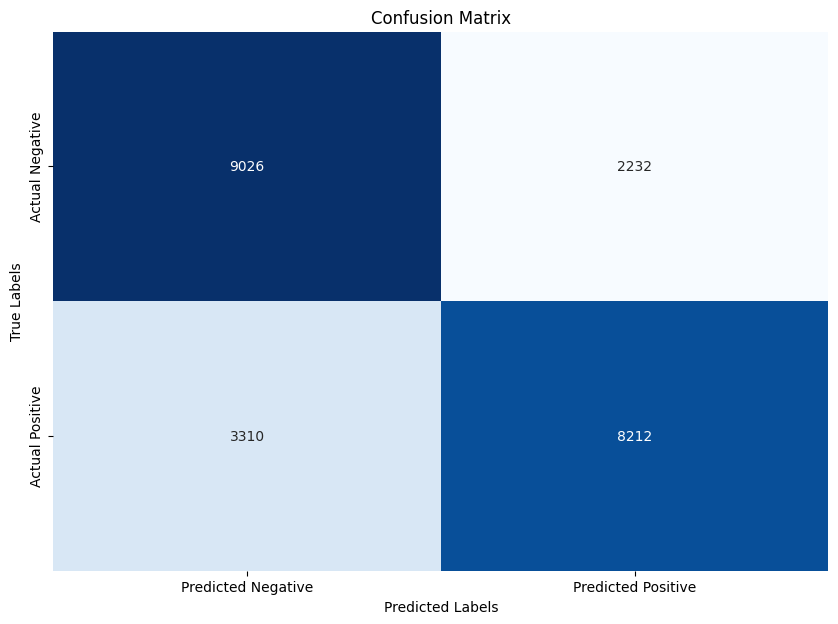

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.80      0.77     11258
           1       0.79      0.71      0.75     11522

    accuracy                           0.76     22780
   macro avg       0.76      0.76      0.76     22780
weighted avg       0.76      0.76      0.76     22780



In [11]:
# Make predictions on the test data
y_pred_dt = dt_model.predict(X_test_transformed)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_dt)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_dt, average='weighted')
recall = recall_score(y_test, y_pred_dt, average='weighted')
f1 = f1_score(y_test, y_pred_dt, average='weighted')

print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_dt)
# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report for detailed metrics
class_report = classification_report(y_test, y_pred_dt)
print('Classification Report:')
print(class_report)


#### Xgboost Model

In [12]:
# Initializing the XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')

In [13]:
# Perform cross-validation
xgb_cv_scores  = cross_val_score(xgb_model, X_train_transformed, y_train, cv=5, scoring='accuracy')

# Print cross-validation results for XGBoost
print("XGBoost Cross-Validation Scores: ", xgb_cv_scores)
print("XGBoost Mean Accuracy: ", np.mean(xgb_cv_scores))


XGBoost Cross-Validation Scores:  [0.82298068 0.82264172 0.82137958 0.82247709 0.82565988]
XGBoost Mean Accuracy:  0.823027789269771


In [14]:
# Fit the model on the training data
xgb_model.fit(X_train_transformed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [15]:
# Make predictions on the training data
y_train_pred_xgb = xgb_model.predict(X_train_transformed)

# Evaluate the accuracy of the model on the training data
train_accuracy = accuracy_score(y_train, y_train_pred_xgb)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')


Training Accuracy: 87.24%


Accuracy: 82.27%
Precision: 82.96%
Recall: 82.27%
F1 Score: 82.16%


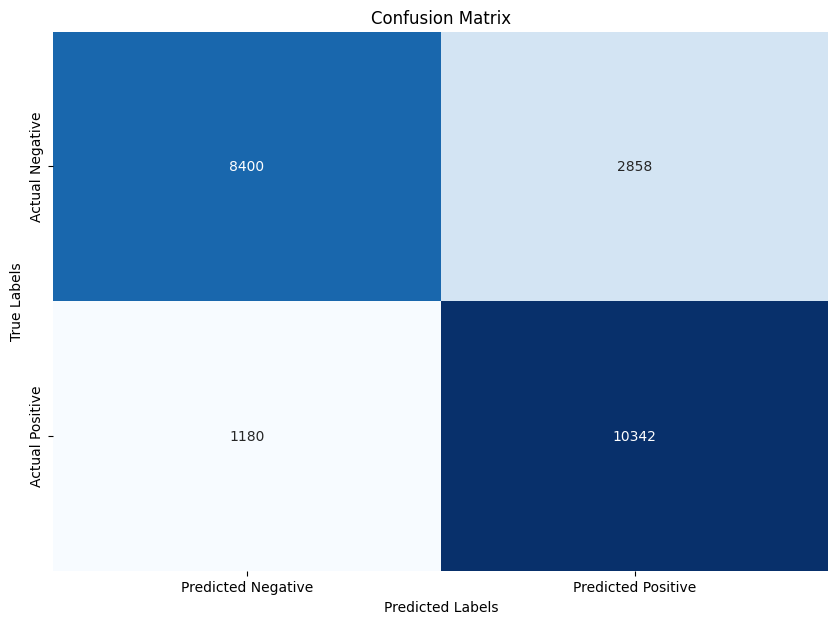

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.75      0.81     11258
           1       0.78      0.90      0.84     11522

    accuracy                           0.82     22780
   macro avg       0.83      0.82      0.82     22780
weighted avg       0.83      0.82      0.82     22780



In [16]:
# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test_transformed)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_xgb, average='weighted')
recall = recall_score(y_test, y_pred_xgb, average='weighted')
f1 = f1_score(y_test, y_pred_xgb, average='weighted')

print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report for detailed metrics
class_report = classification_report(y_test, y_pred_xgb)
print('Classification Report:')
print(class_report)


#### SVM

In [ ]:
# Create and train the SVM model
svm_model = SVC(kernel='rbf')

In [ ]:
# # Perform cross-validation on the SVM model
# svm_cv_scores = cross_val_score(svm_model, X_train_transformed, y_train, cv=5, scoring='accuracy')

# # Print cross-validation results for SVM
# print("SVM Cross-Validation Scores: ", svm_cv_scores)
# print("SVM Mean Accuracy: ", np.mean(svm_cv_scores))


In [ ]:
# Fit the model on the training data
svm_model.fit(X_train_transformed, y_train)

SVC()

In [ ]:
# Make predictions on the test data
y_train_pred_svm = svm_model.predict(X_train_transformed)

# Evaluate the accuracy of the model on the training data
train_accuracy = accuracy_score(y_train, y_train_pred_svm)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')


Training Accuracy: 77.07%


Accuracy: 76.12%
Precision: 78.71%
Recall: 76.12%
F1 Score: 75.50%


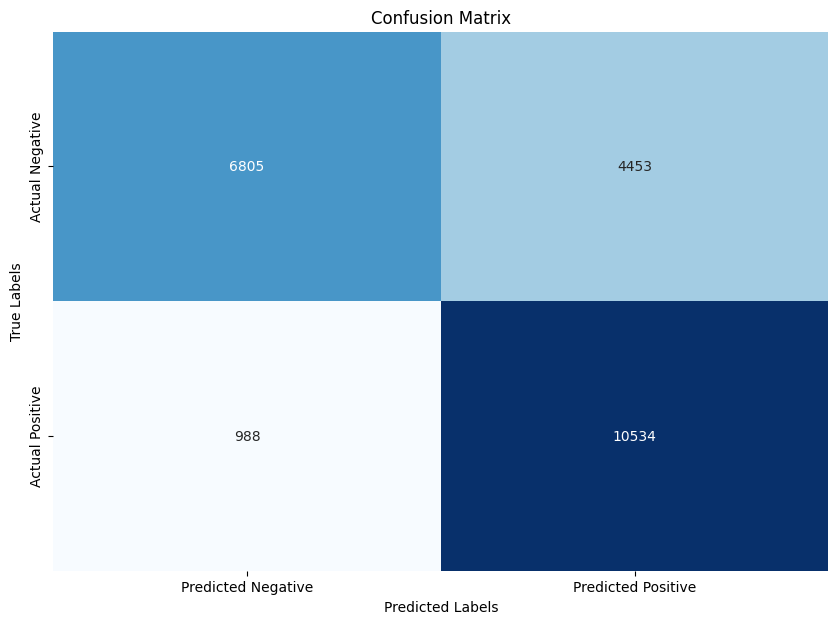

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.60      0.71     11258
           1       0.70      0.91      0.79     11522

    accuracy                           0.76     22780
   macro avg       0.79      0.76      0.75     22780
weighted avg       0.79      0.76      0.76     22780



In [ ]:
# Make predictions on the test data
y_pred_svm = svm_model.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred_svm)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_svm, average='weighted')
recall = recall_score(y_test, y_pred_svm, average='weighted')
f1 = f1_score(y_test, y_pred_svm, average='weighted')

print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)
# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report for detailed metrics
class_report = classification_report(y_test, y_pred_svm)
print('Classification Report:')
print(class_report)


#### Hyperparameter Tuning using Optuna

In [ ]:
# pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.0 MB/s eta 0:00:00


In [ ]:
# Objective function for Optuna
def objective_dt(trial):
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    dt_model = DecisionTreeClassifier(max_depth=max_depth,
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf,
                                      criterion=criterion,
                                      random_state=42)
    dt_model.fit(X_train_transformed, y_train)
    y_pred = dt_model.predict(X_test_transformed)
    return accuracy_score(y_test, y_pred)

# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective_dt, n_trials=100)

print(f"Best hyperparameters: {study.best_params}")
print(f"Best accuracy: {study.best_value}")


[I 2024-11-07 01:43:55,879] A new study created in memory with name: no-name-d3b7d154-dda4-47ec-8e9d-550a1e37eaf7
[I 2024-11-07 01:43:57,012] Trial 0 finished with value: 0.634196663740123 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.634196663740123.
[I 2024-11-07 01:43:59,383] Trial 1 finished with value: 0.7262949956101844 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 1 with value: 0.7262949956101844.
[I 2024-11-07 01:44:02,438] Trial 2 finished with value: 0.7505706760316067 and parameters: {'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 2 with value: 0.7505706760316067.
[I 2024-11-07 01:44:06,540] Trial 3 finished with value: 0.7529850746268657 and parameters: {'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 3 with value

Best hyperparameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'gini'}
Best accuracy: 0.7607550482879719


Accuracy: 75.83%
Precision: 76.13%
Recall: 76.05%
F1 Score: 76.09%


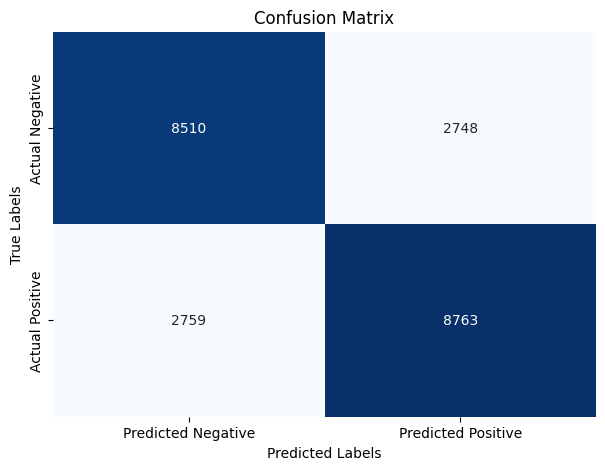

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     11258
           1       0.76      0.76      0.76     11522

    accuracy                           0.76     22780
   macro avg       0.76      0.76      0.76     22780
weighted avg       0.76      0.76      0.76     22780



In [ ]:
# Train the model with best hyperparameters
best_dt_model = DecisionTreeClassifier(max_depth=19, min_samples_split=3,
                                       min_samples_leaf=1, criterion='gini')
best_dt_model.fit(X_train_transformed, y_train)

# Make predictions on the test data
y_pred_dt = best_dt_model.predict(X_test_transformed)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_dt)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate precision, recall, and F1 score (for binary classification)
precision = precision_score(y_test, y_pred_dt)
recall = recall_score(y_test, y_pred_dt)
f1 = f1_score(y_test, y_pred_dt)

print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_dt)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report for detailed metrics
class_report = classification_report(y_test, y_pred_dt)
print('Classification Report:')
print(class_report)


In [ ]:
#pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.2 MB/s eta 0:00:00


In [ ]:

# Define the model
xgb_model = XGBClassifier()

# Define the hyperparameters to tune using Bayesian optimization
search_space_xgb = {
    'learning_rate': (0.01, 0.2),
    'n_estimators': (50, 500),
    'max_depth': (3, 10),
    'subsample': (0.6, 1.0)
}

# Set up Bayesian optimization
bayes_search_xgb = BayesSearchCV(estimator=xgb_model, search_spaces=search_space_xgb, cv=5, n_jobs=-1, verbose=2)

# Fit the model
bayes_search_xgb.fit(X_train_transformed, y_train)

# Print the best parameters and best score
print(f"Best parameters: {bayes_search_xgb.best_params_}")
print(f"Best cross-validation score: {bayes_search_xgb.best_score_}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Accuracy: 86.78%
Precision: 84.19%
Recall: 90.93%
F1 Score: 87.43%


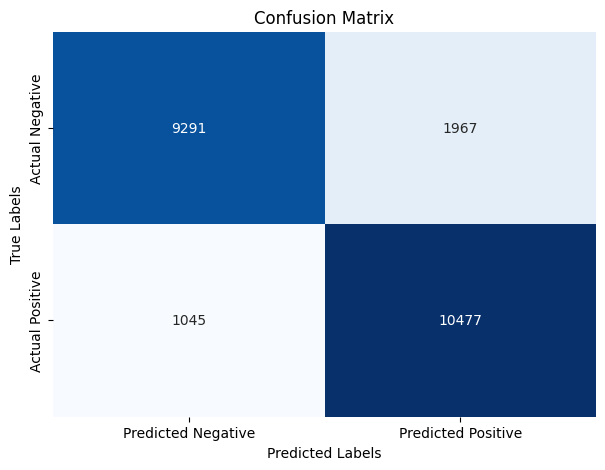

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     11258
           1       0.84      0.91      0.87     11522

    accuracy                           0.87     22780
   macro avg       0.87      0.87      0.87     22780
weighted avg       0.87      0.87      0.87     22780



In [10]:
# Train the model with best hyperparameters
best_xgboost_model = xgb.XGBClassifier(
    learning_rate=0.09678342891062063,
    max_depth=10,
    n_estimators=500,
    subsample=0.8617993610169645,
    random_state=42
)

# Train the model on the full training set
best_xgboost_model.fit(X_train_transformed, y_train)

# Make predictions on the test set
y_pred_xgb = best_xgboost_model.predict(X_test_transformed)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate precision, recall, and F1 score (for binary classification)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)

print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report for detailed metrics
class_report = classification_report(y_test, y_pred_xgb)
print('Classification Report:')
print(class_report)


In [ ]:
def objective_svm(trial):
    # Suggest hyperparameters
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    # Initialize the model with the suggested hyperparameters
    svm_model = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)

    # Train the model on the training data
    svm_model.fit(X_train_transformed, y_train)

    # Make predictions on the test set
    y_pred = svm_model.predict(X_test_transformed)

    # Return the accuracy score as the objective function value
    return accuracy_score(y_test, y_pred)

# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective_svm, n_trials=100)

print(f"Best hyperparameters: {study.best_params}")
print(f"Best accuracy: {study.best_value}")


[I 2024-11-06 22:17:52,478] A new study created in memory with name: no-name-df19d591-fe10-4f59-aa21-c9e8d12102fa
[I 2024-11-06 22:26:45,215] Trial 0 finished with value: 0.5944249341527655 and parameters: {'C': 0.0015212733238389666, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.5944249341527655.


In [11]:
importances = best_xgboost_model.feature_importances_
feature_names=X.columns
feature_imp_df = pd.DataFrame({'Feature': X.columns.tolist(), 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
feature_imp_df

,Feature,Gini Importance
15,et0_fao_evapotranspiration,0.093014
23,soil_temperature_7_to_28cm,0.064431
22,soil_temperature_0_to_7cm,0.060128
4,precipitation,0.047848
13,cloud_cover_mid,0.047548
17,wind_speed_10m,0.040611
1,relative_humidity_2m,0.038090
26,soil_moisture_0_to_7cm,0.036438
8,weather_code,0.035911
10,surface_pressure,0.034821


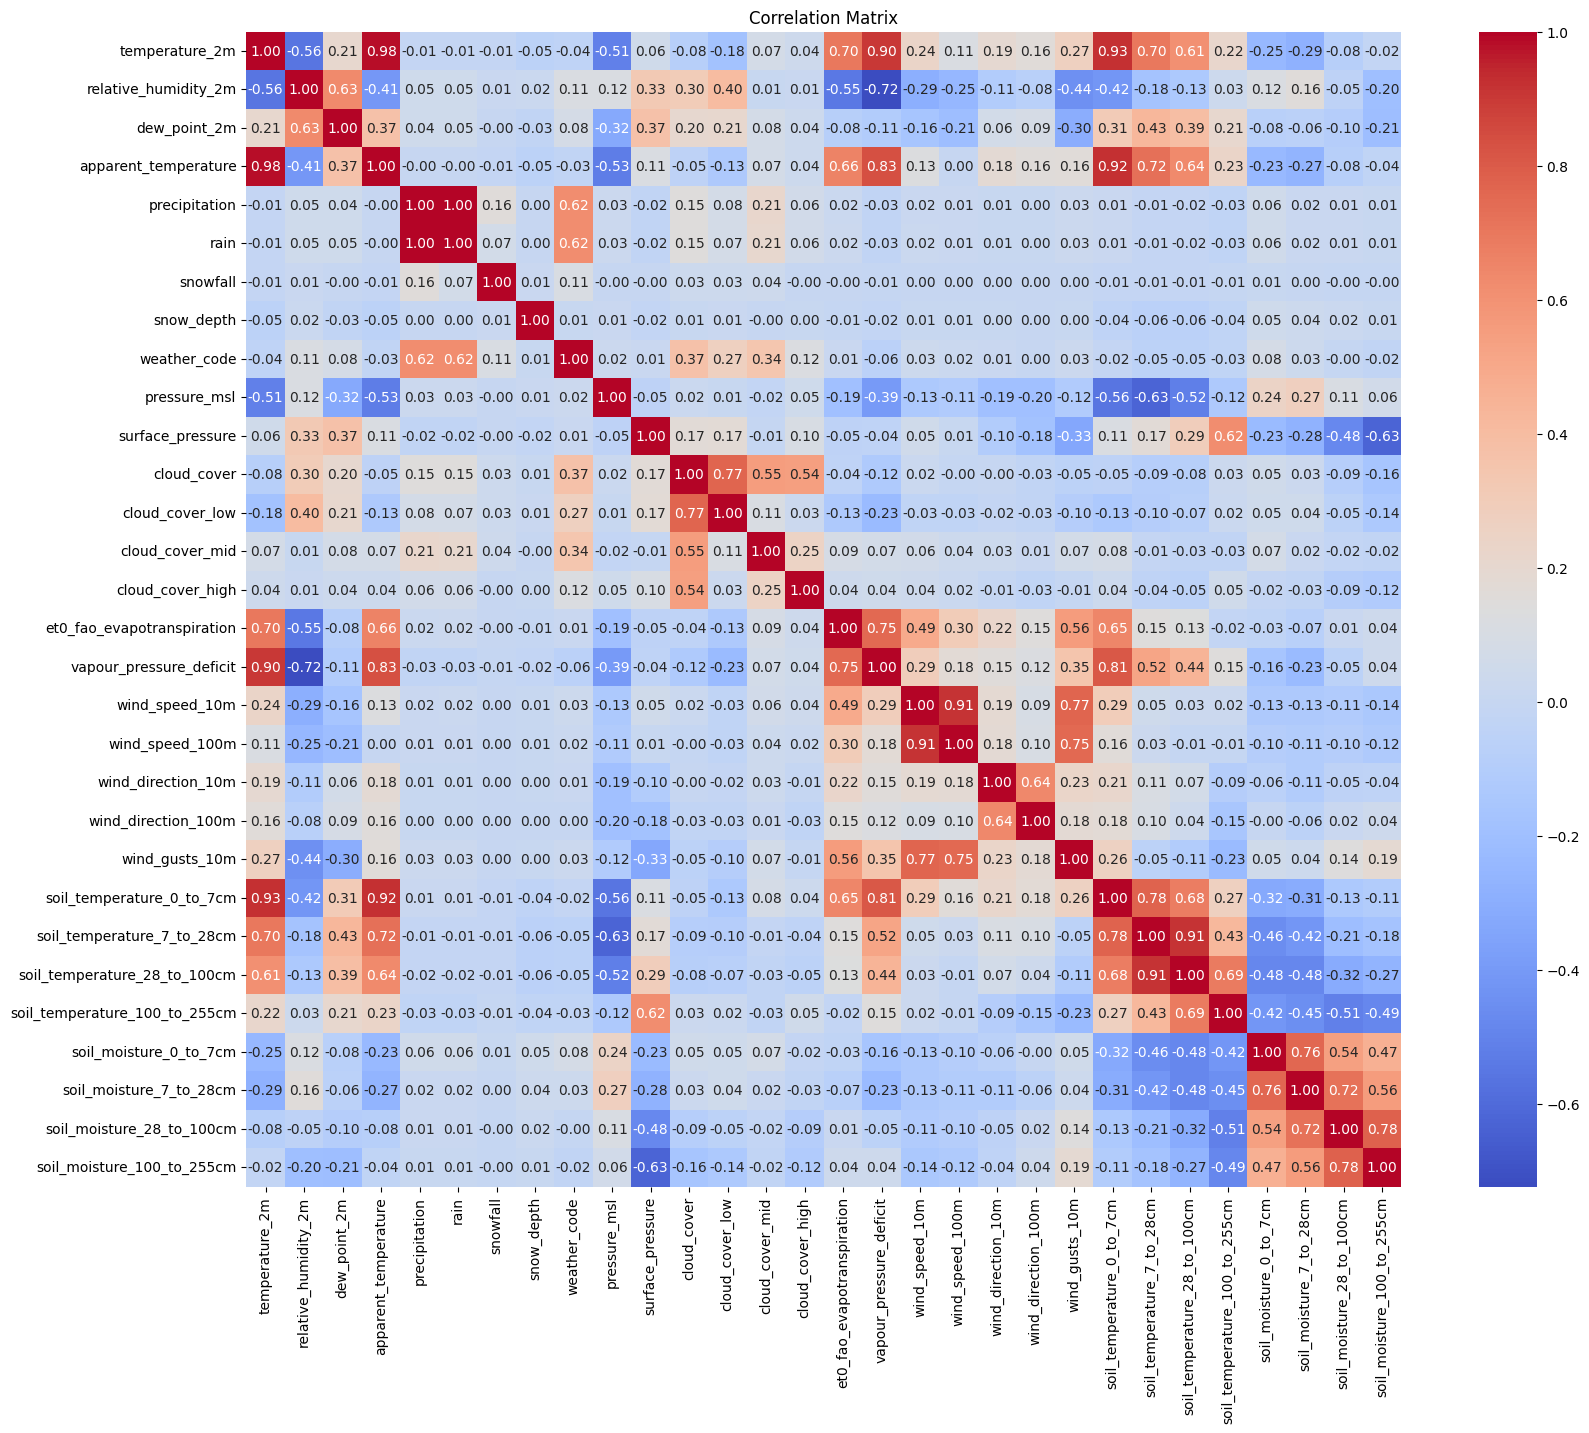

In [12]:
# Assuming X is your feature DataFrame
correlation_matrix = X.corr()

# Plotting the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [14]:
y_scores = best_xgboost_model.predict_proba(X_test_transformed)[:, 1]

AUC-ROC Score: 0.9310789436038832


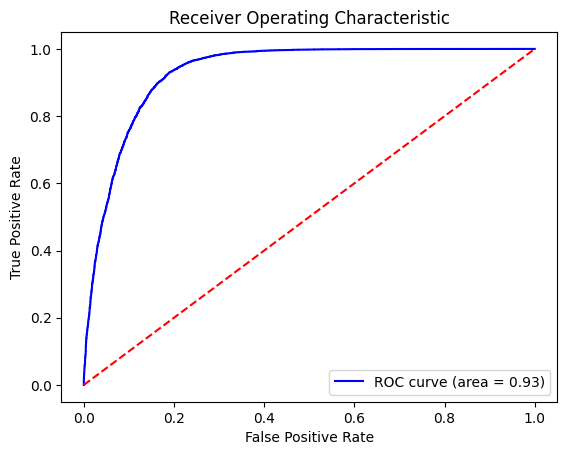

In [17]:
# Calculate AUC-ROC score
auc_score = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_score)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()